# Assignment 1
## K-Nearest Neighbors

This is the start of the assignent. Let us start by taking a peak into the dataset.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
import pandas as pd
from sklearn import metrics, neighbors, model_selection, tree, preprocessing, compose
import heapq
import time
import seaborn
from functools import reduce

In [168]:
# unpickling the data
with open('data.npy', 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data)
df.columns = ['Index','ResNet','VIT','Class','Time']
print('Number of samples is ', len(df))

Number of samples is  1500


### Plotting the data

Now let us visualize this distribution of labels by plotting it using the matplotlib library

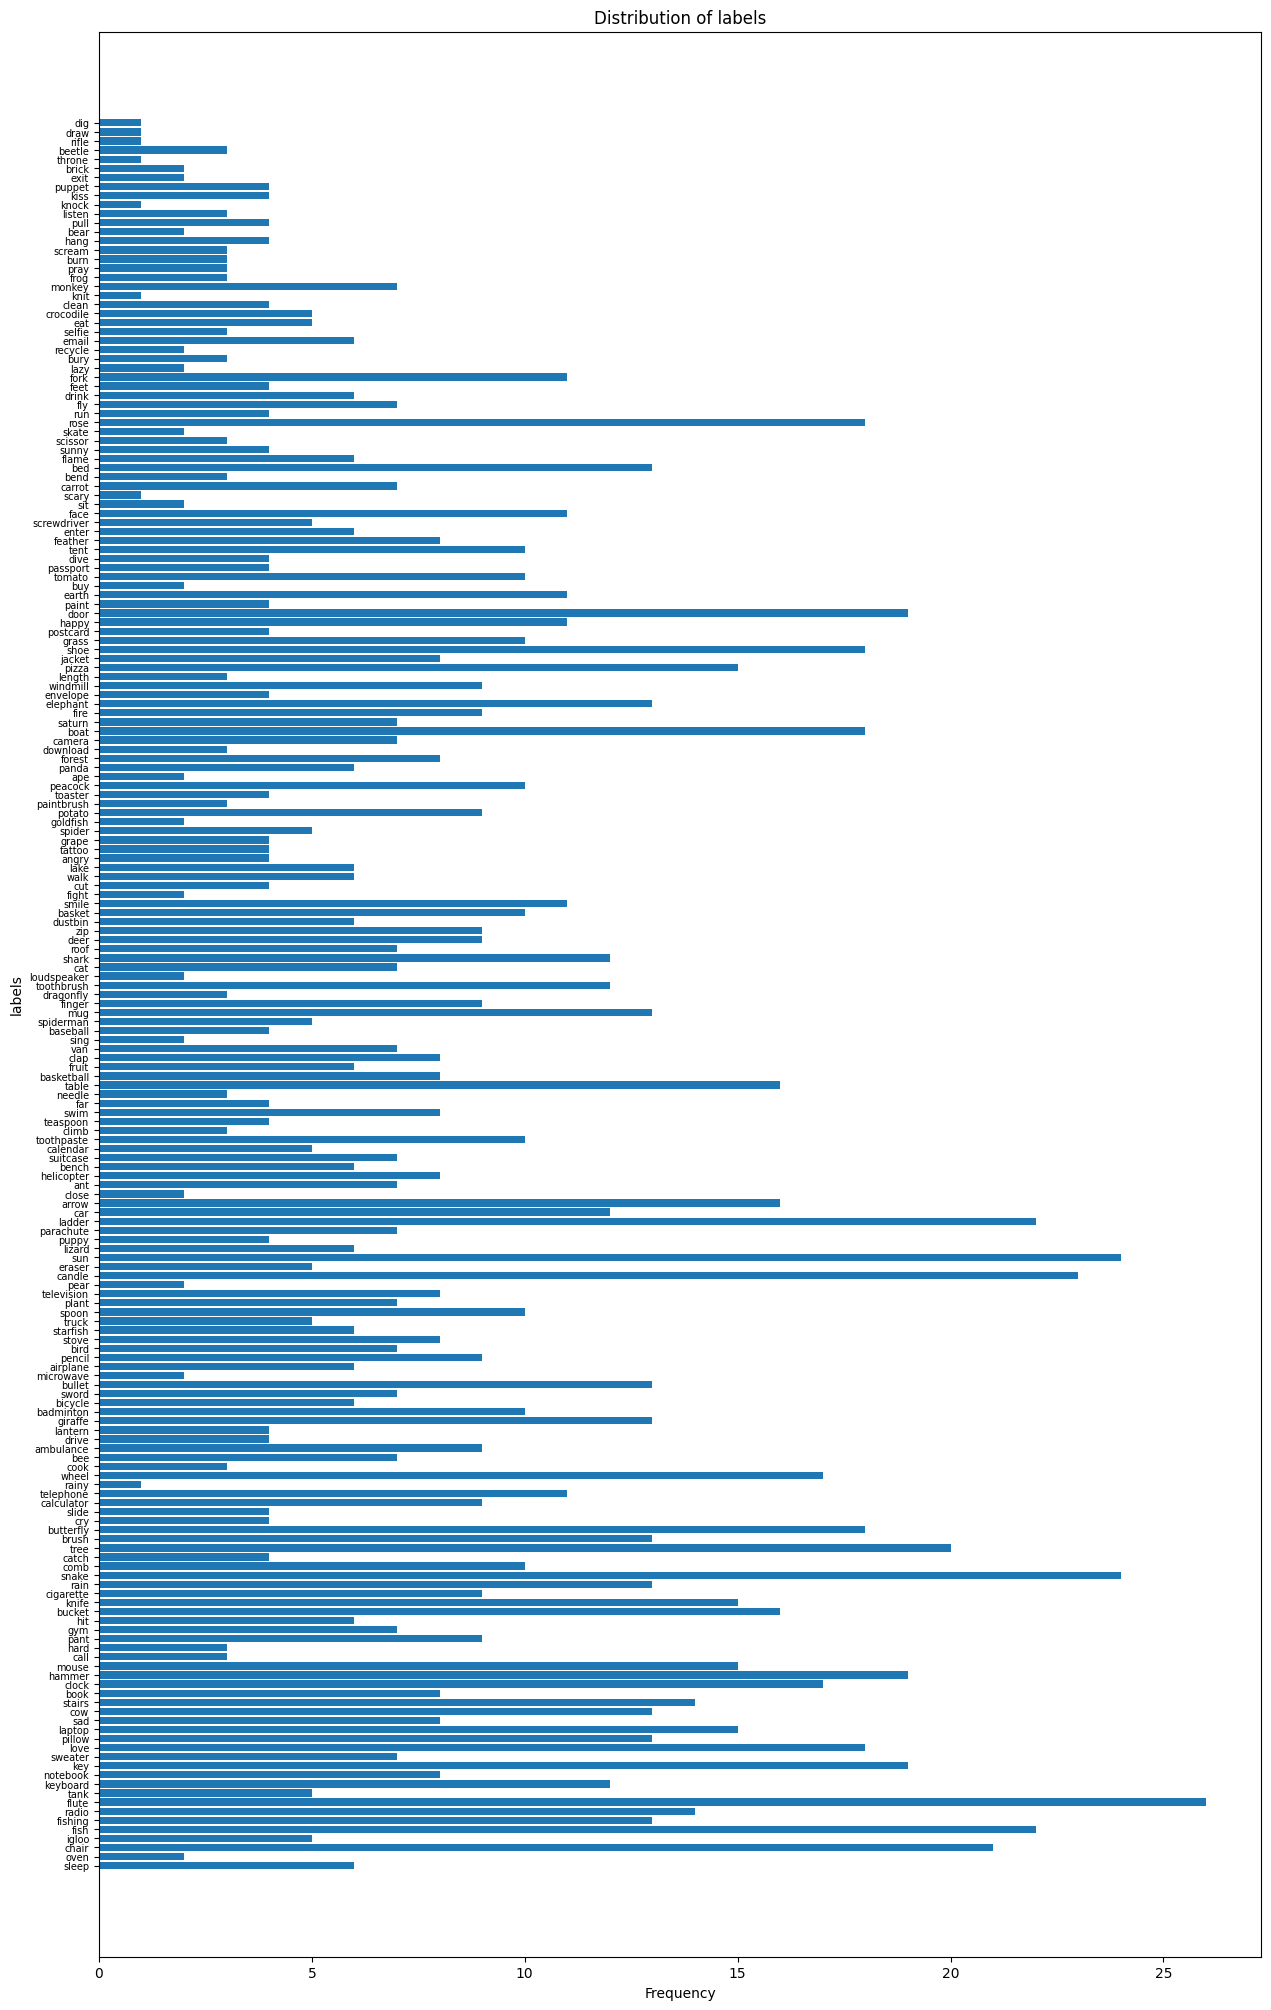

In [169]:
counter = Counter(df['Class']) # Computing a dictionary with counts of all labels

count = list(counter.values())
labels = list(counter.keys())

plt.figure(figsize=(15,25)) # Setting the plot size to accomodate the labels
plt.barh(labels, count) # Plotting a horizontal bar plot for all the labels
plt.gca().set(title='Distribution of labels', ylabel='labels', xlabel='Frequency')
plt.yticks(fontsize = 7)
plt.show()

### k-NN Implementation

We will create a class for our k-NN model. The class will take input the encoder type, k, and the distance metric. We will write the distance functions in the class, and then a function to give the prediction of its class given the inputs of the above 3 hyperparameters.

In [170]:
class kNN():
    def __init__(self):
        self.pred = []
        self.report = ''
        self.metrics = {'Accuracy': 0.0, 'F1-score':0.0, 'Recall':0.0, 'Precision':0.0}

    def euclid(self, embed1, embed2):
        return np.sqrt(np.sum((embed1 - embed2)*(embed1 - embed2), axis = 1)) # Computes the Euclidean distance

    def manhattan(self, embed1, embed2):
        return np.sum(np.abs(embed1 - embed2), axis = 1) # Computes the Manhattan distance

    def cosine(self, embed1, embed2):
        return 1 - np.dot(np.squeeze(embed1), np.squeeze(embed2).T)/(np.linalg.norm(embed1)*np.linalg.norm(embed2, axis = 1)) # Computes the Cosine distance
  

    def split(self, i, data):# i is the training mark in percent of data we want as training data
        i = i*len(data)
        training_data = data[:int(i), :] # splitting training data
        validation_data = data[int(i):, :] # splitting testing data

        return training_data, validation_data

    def prediction(self, test_sample, training_data, encoder, dist_metric, k=1):
        embed_col = 1 if encoder == 'ResNet' else 2

        test_embed = test_sample[embed_col] # Extracting embeddings, given the encoder
        training_embeds = np.vstack(training_data[:, embed_col])
        train_class = np.vstack(training_data[:, 3])
        

        dist = dist_metric(test_embed , training_embeds)
        dist_dupl = dist # Computing distances with every vector in test set.
        heapq.heapify(list(dist_dupl)) # Sorting the accuracies using a heap
        
        k_nearest = heapq.nsmallest(k, dist_dupl)
        
            
        classes = [train_class[np.where(dist == k_nearest[i])] for i in range(len(k_nearest))]
        
        class_count = Counter(np.squeeze(np.vstack(classes).T))

        self.pred.append(max(class_count, key= lambda x: class_count[x]))
        

    def inference(self, test_data, training_data, encoder, dist_metric, k=1):
        self.pred = []
        for i in range(len(test_data)):
            self.prediction(test_data[i, :], training_data, encoder, dist_metric, k)

        self.report = metrics.classification_report(test_data[:, 3], self.pred, zero_division = 0)
        self.metrics['Accuracy'] = metrics.accuracy_score(test_data[:, 3], self.pred)
        self.metrics['F1-score'] = metrics.f1_score(test_data[:, 3], self.pred, average = 'micro')
        self.metrics['Recall'] = metrics.recall_score(test_data[:, 3], self.pred, average = 'micro')
        self.metrics['Precision'] = metrics.precision_score(test_data[:, 3], self.pred, average = 'micro')
        
        return metrics.accuracy_score(test_data[:, 3], self.pred)

Now let us test our model with some arbitrary distance metircs, k-value as well as encoder type.

In [173]:
model = kNN()
training_data, validation_data = model.split(0.8, data)
model.inference(validation_data, training_data, 'VIT', model.cosine, 9)
print('Predictions:', model.pred)
print('True labels:', validation_data[:, 3])
print(model.report)
print(model.metrics)

Predictions: ['shark', 'door', 'passport', 'fish', 'toothpaste', 'mouse', 'candle', 'sun', 'mouse', 'sun', 'ladder', 'face', 'starfish', 'fish', 'television', 'snake', 'happy', 'shark', 'pillow', 'fishing', 'mouse', 'flute', 'sun', 'feather', 'happy', 'butterfly', 'car', 'toothpaste', 'bear', 'flute', 'sad', 'sun', 'bucket', 'sun', 'roof', 'calculator', 'table', 'mug', 'throne', 'butterfly', 'cow', 'flame', 'loudspeaker', 'ladder', 'tree', 'love', 'snake', 'cow', 'snake', 'wheel', 'giraffe', 'pencil', 'knife', 'tree', 'wheel', 'radio', 'cow', 'sword', 'snake', 'clock', 'baseball', 'butterfly', 'table', 'knife', 'key', 'rain', 'wheel', 'snake', 'loudspeaker', 'tree', 'candle', 'dive', 'tree', 'love', 'sing', 'tree', 'door', 'notebook', 'hammer', 'keyboard', 'clock', 'monkey', 'door', 'laptop', 'mouse', 'ladder', 'feather', 'shark', 'calculator', 'fishing', 'arrow', 'pillow', 'suitcase', 'key', 'flute', 'chair', 'hammer', 'ladder', 'knife', 'stairs', 'spoon', 'laptop', 'chair', 'ladder',

### Best Triplet

Now we will find the 20 best (k, encoder, distance metric) triplet. We will iterate for every encoder and distance metric while only making sure k ranges from all odd values between 1 to 30. The below takes a while to run(2 to 3 min), so only run for verification of code.

In [8]:
k_values = [i for i in range(3, 30, 2)]
encoder_type = ['ResNet', 'VIT']
distance_metric = [model.euclid, model.manhattan, model.cosine]

accuracy_dict = {model.inference(validation_data, training_data, encoder_type[i], distance_metric[j], k_values[k]) : (encoder_type[i], distance_metric[j], k_values[k]) for i in range(len(encoder_type)) for j in range(len(distance_metric)) for k in range(len(k_values))}
tuple = list(accuracy_dict.items())
heapq.heapify(tuple) # Computed a dictionary with accuracy values and the triplet giving the accuracy value. Now creating a heap to obtain best triplets


In [9]:
best_acc = heapq.nlargest(20, tuple)
for i in range(len(best_acc)):
    Accuracy, triplet = best_acc[i]
    encoder, metric, k = triplet
    print('Triplet:',encoder, metric.__name__, k, '| Accuracy:',Accuracy)

Triplet: VIT euclid 9 | Accuracy: 0.30666666666666664
Triplet: VIT cosine 9 | Accuracy: 0.3
Triplet: VIT manhattan 9 | Accuracy: 0.2966666666666667
Triplet: VIT manhattan 11 | Accuracy: 0.29333333333333333
Triplet: VIT cosine 11 | Accuracy: 0.29
Triplet: VIT manhattan 19 | Accuracy: 0.2866666666666667
Triplet: VIT cosine 21 | Accuracy: 0.28
Triplet: VIT cosine 23 | Accuracy: 0.27666666666666667
Triplet: VIT cosine 5 | Accuracy: 0.2733333333333333
Triplet: VIT cosine 25 | Accuracy: 0.27
Triplet: VIT cosine 29 | Accuracy: 0.26666666666666666
Triplet: VIT cosine 3 | Accuracy: 0.2633333333333333
Triplet: VIT euclid 29 | Accuracy: 0.26
Triplet: VIT cosine 27 | Accuracy: 0.25666666666666665
Triplet: ResNet manhattan 7 | Accuracy: 0.25
Triplet: ResNet manhattan 19 | Accuracy: 0.23666666666666666
Triplet: ResNet manhattan 21 | Accuracy: 0.23333333333333334
Triplet: ResNet manhattan 15 | Accuracy: 0.23
Triplet: ResNet cosine 11 | Accuracy: 0.22333333333333333
Triplet: ResNet cosine 17 | Accurac

### Accuracy vs K

Now we will plot the Accuracy for different k values for an encoder and metric type of our choice. From the top 20 triplets above, we see that encoder VIT with metric euclid and manhattan have the highest accuracy so let us analyze the plot for both choices of encoder and metric pair. We can also analyze the accuracy for ResNet encoder and observe the accuracy change. We are already aware that cosine is not a good metric so we will not be plotting the accuracy for cosine

In [10]:
accuracy_with_euclid = [model.inference(validation_data, training_data, 'VIT', model.euclid, k_values[i]) for i in range(len(k_values))]
accuracy_with_manhattan = [model.inference(validation_data, training_data, 'VIT', model.manhattan, k_values[i]) for i in range(len(k_values))]
# Takes a minute to run

In [11]:
accuracy_with_euclid_resnet = [model.inference(validation_data, training_data, 'ResNet', model.euclid, k_values[i]) for i in range(len(k_values))]
accuracy_with_manhattan_resnet = [model.inference(validation_data, training_data, 'ResNet', model.manhattan, k_values[i]) for i in range(len(k_values))]

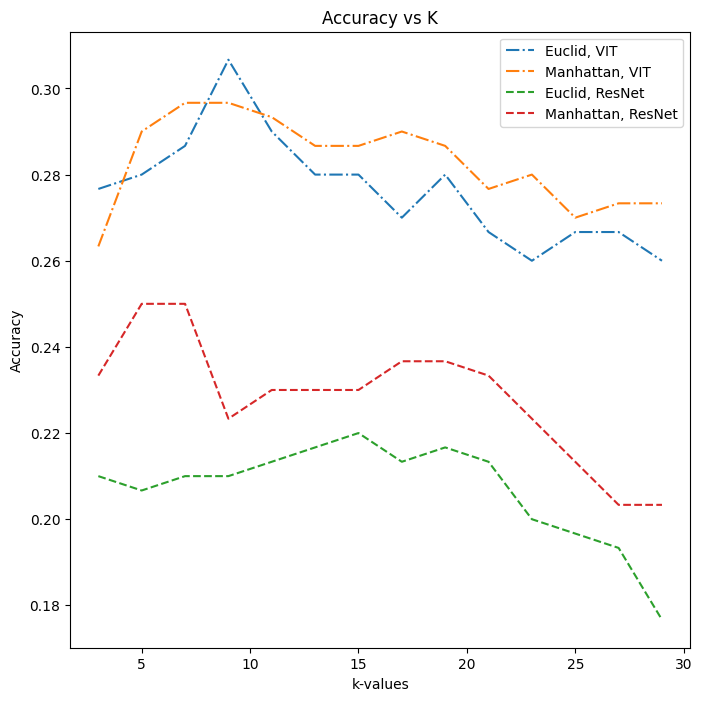

In [12]:
plt.figure(figsize = (8, 8))
plt.plot(k_values, accuracy_with_euclid, '-.', label = 'Euclid, VIT')
plt.plot(k_values, accuracy_with_manhattan, '-.', label = 'Manhattan, VIT')
plt.plot(k_values, accuracy_with_euclid_resnet,'--', label = 'Euclid, ResNet')
plt.plot(k_values, accuracy_with_manhattan_resnet,'--', label = 'Manhattan, ResNet')
plt.xlabel('k-values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.legend(loc = 'upper right')
plt.show()

We make a very worthy conclusion from the above plots.For VIT, we can see that euclid gives higher accuracy but only for a small set of k values which is (3, 5, 7, 9, 11, 13, 15) while manhattan gives higher accuracy (not higher than the max of euclid) for a large range of k values. We can choose our metric based on what kind of k value we need to choose.

We can also conclude that classification with the encoder type ResNet does worse than using the enodings from VIT. This is because of the performance of the encoders. ViT has the ability to capture spatial information giving better encodings for the drawings. 

### Optimization

Our model already uses the concept of Vectorization which makes it optimized already. We will compare the inference time for our model and the inbuilt sklearn knn model. We will get the time using the time library.

In [183]:
our_inference1 = time.time()
our_accuracy = model.inference(validation_data, training_data, 'VIT', model.euclid, 9) # Computing the inference of our model with the same split used untill now
our_inference2 = time.time()

X = np.vstack(df['VIT'])# Preparing the data to use sklearns knn
Y = df['Class']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = 0.8) 

sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
sk_model.fit(X_train, Y_train)

sk_inference1 = time.time()
y_pred = sk_model.predict(X_test) # Computing the inference of sklearn model with the same split used untill now.
sk_inference2 = time.time()

sk_accuracy = metrics.accuracy_score(Y_test, y_pred)
print(sk_accuracy)
print(our_accuracy)

0.14583333333333334
0.30666666666666664


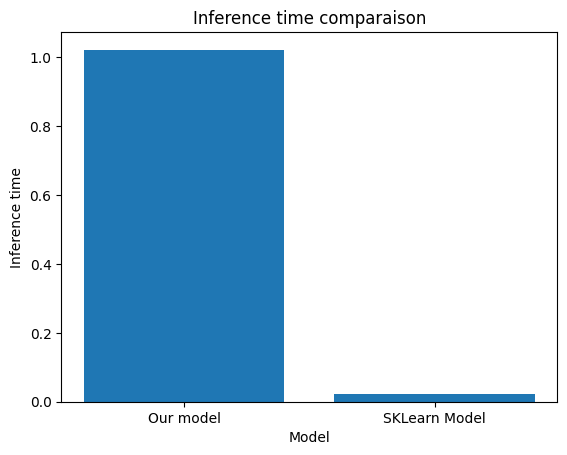

In [184]:
plt.bar(['Our model', 'SKLearn Model'], [our_inference2 - our_inference1, sk_inference2 - sk_inference1])
plt.title('Inference time comparaison')
plt.xlabel('Model')
plt.ylabel('Inference time')
plt.show()

We can observe that SKLearn performs much faster than our model. Now let us plot the inference time for both the models for different amount of splits.

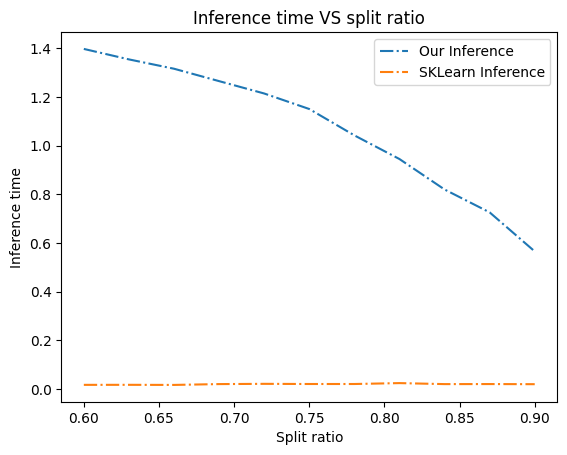

In [15]:
our_inference = [0]*11
sk_inference = [0]*11

for i in range(11):
    train_data, valid_data = model.split(0.6 + (i)*0.03, data)

    our_inference1 = time.time()
    model.inference(valid_data, train_data, 'VIT', model.euclid, 9) # Computing the inference of our model with a changing split.
    our_inference2 = time.time()

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = 0.6 + i*0.03)
    sk_model.fit(X_train, Y_train)

    sk_inference1 = time.time()
    y_pred = sk_model.predict(X_test) # Computing the inference of sklearn model with a changing split.
    sk_inference2 = time.time()    

    our_inference[i] = our_inference2 - our_inference1
    sk_inference[i] = sk_inference2 - sk_inference1

split = [0.6 + i* 0.03 for i in range(11)]
plt.plot(split, our_inference, '-.', label = 'Our Inference')
plt.plot(split, sk_inference, '-.', label = 'SKLearn Inference')
plt.xlabel('Split ratio')
plt.ylabel('Inference time')
plt.title('Inference time VS split ratio')
plt.legend(loc = 'upper right')
plt.show()

Here, we can observe that the inference time decreases with an increase in split ratio as the number of test samples keep decreasing

## Decision Trees

This is the start of part 2 of the assignment where we will implement decision trees. Let us start by visualizing the data we are given.

In [7]:
Data = pd.read_csv('advertisement.csv')
print(Data.head())
Df = pd.DataFrame(Data)

   age  gender        income    education  married  children           city  \
0   45    Male  61271.953359       Master    False         3    Lake Sheila   
1   24  Female  53229.101074  High School    False         1   Crystalburgh   
2   45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3   19    Male  48950.246384          PhD    False         0  Williamshaven   
4   29  Female  44792.627094       Master    False         0       New Paul   

    occupation  purchase_amount most bought item  \
0       Doctor        87.697118          monitor   
1  Businessman       115.135586         lipstick   
2     Engineer       101.694559         biscuits   
3       Lawyer        97.964887            maggi   
4  Businessman        86.847281           carpet   

                             labels  
0       electronics clothing sports  
1                  furniture beauty  
2  clothing electronics food sports  
3                              food  
4                     

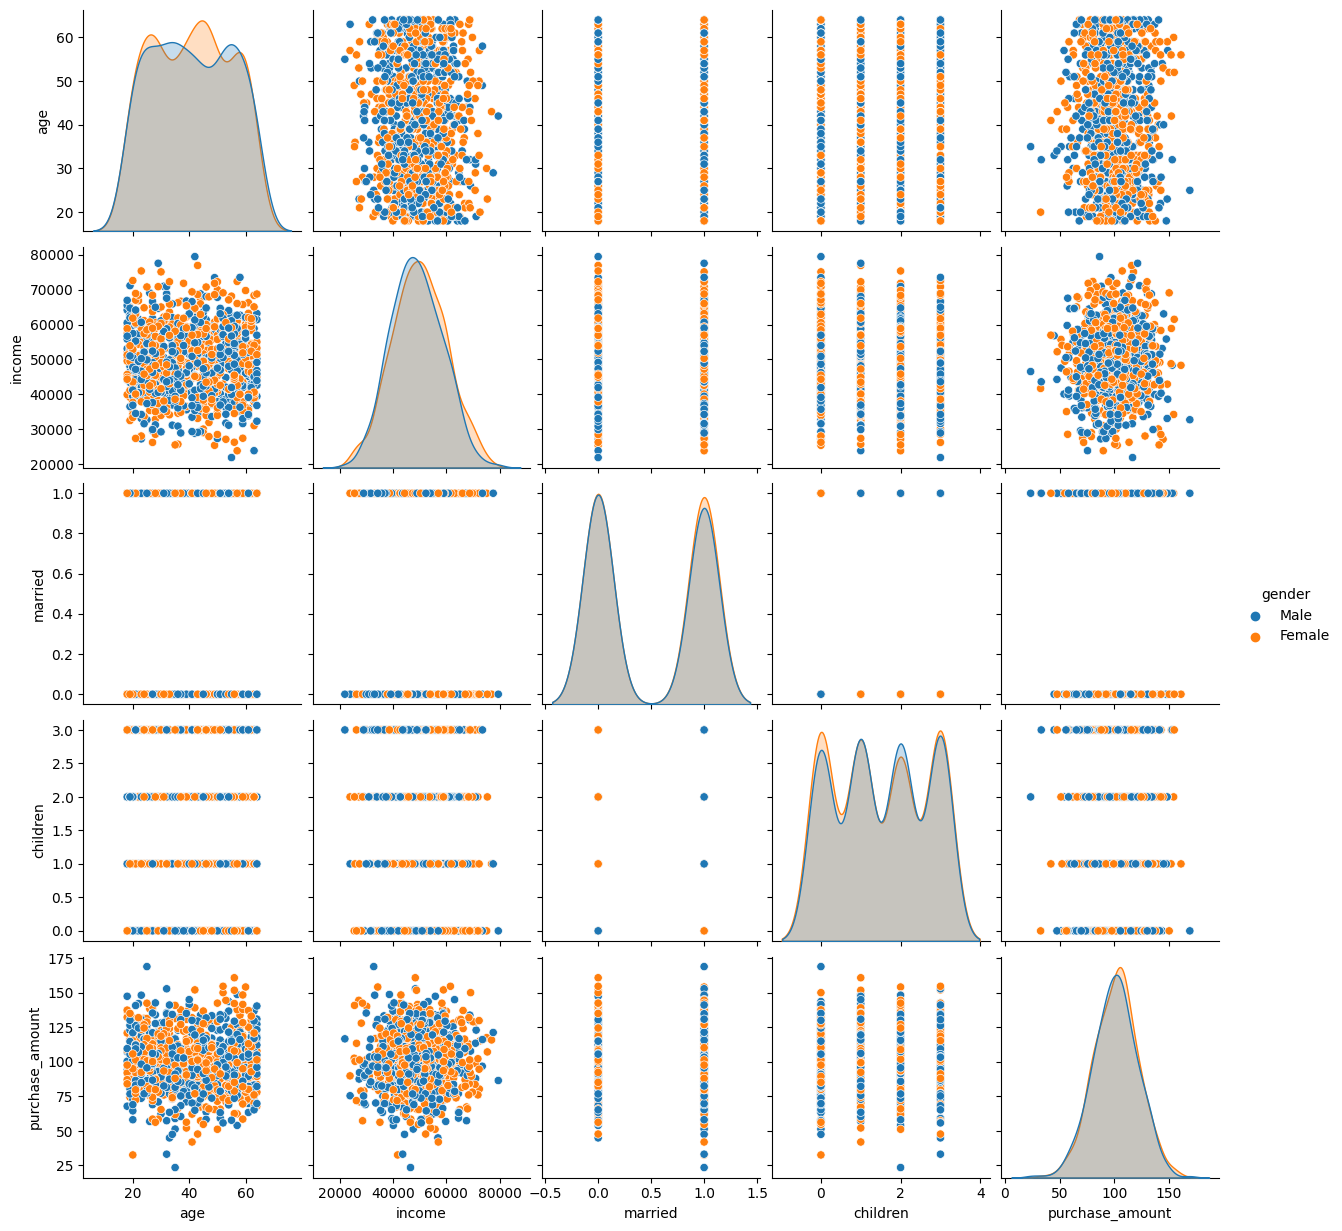

In [8]:
seaborn.pairplot(Df, hue = 'gender') # Visualizing the data using pairplots.
plt.show()

Since our data has alot of classes, it would be easier to visualize it using a pairplot to see the relation among all the different attributes given in the data. Most of the distributions given in the plots show that it has an equal distribution.

Now we will implement the Decision Tree implementation by making a class which makes a model using sklearn. We will also preprocess the data within the class.

In [9]:
class DTree():
    def __init__(self):
        self.metrics = {'Accuracy': 0.0, 'F1_micro' : 0.0, 'F1_macro':0.0, 'Precision':0.0, 'Recall':0.0, 'Confusion_matrix':0.0}

    def get_pset(self, sets):
        PowerSet = lambda s: reduce(lambda P, x: P + [subset | {x} for subset in P], s, [set()]) # Obtaining the power set of a list_
        pslabels = PowerSet(sets)
        return pslabels


    def preprocessing_ps(self, data): # Power Set Formulation
        data = [list(s.split(' ')) for s in list(data.labels)] #Splitting the labels into individual words
        mlb = preprocessing.MultiLabelBinarizer() # Using sklearn to obtain the different classes
        mlb.fit(data)

        pslabels = self.get_pset(mlb.classes_) # Obtain power set of classes as well as labels

        one_hot = np.zeros((len(data), len(pslabels))) # Obtaining one hot encodings
        for i in range(len(data)):
            one_hot[i, pslabels.index(set(data[i]))] = 1
        return one_hot

    
    def preprocessing_mo(self, data): # Multi Output Formulation
        data = [list(s.split(' ')) for s in list(data.labels)] #Splitting the labels into individual words
        mlb = preprocessing.MultiLabelBinarizer() # Using sklearn to obtain the different classes
        mlb.fit(data)
    
        one_hot = np.zeros((len(data), len(mlb.classes_)))
        for i in range(len(data)): # creating the OneHot encoding for the data
            for j in range(len(data[i])):
                one_hot[i, np.where(mlb.classes_ == data[i][j])[0][0]] = 1

        return one_hot

    def featurisation(self, data, categorical_cols):
        x = data.drop('labels', axis = 1)
        for features in categorical_cols: # Replacing the categorical columns with numerical values
            x[features].replace(x[features].unique(), list(range(len(x[features].unique()))), inplace = True)
        
        return x
    
    def split(self, X, Y, test_size):
        return model_selection.train_test_split(X, Y, test_size = test_size) # Splitting the data

    def PowerSet(self, max_depth, max_features, criterion, X_train, Y_train, X_test):
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features) # Making the model
        model = model.fit(X_train, Y_train) # training the model
        return model.predict(X_test) # Inference

    def MultiOut(self, max_depth, max_features, criterion, X_train, Y_train, X_test):
        pred = []
        for j in range(8):
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)
            model = model.fit(X_train, Y_train[:, j]) # Creating a decision tree for every class making it a binary classification problem
            pred_x = model.predict(X_test)
            if j == 0:
                pred = pred_x[np.newaxis].T
            else:
                pred = np.concatenate((pred, pred_x[np.newaxis].T), axis = 1)

        return pred
            
    def analyze(self, Y_test, pred):

        self.metrics['Accuracy'] = metrics.accuracy_score(pred, Y_test)
        self.metrics['F1_micro'] = metrics.f1_score(pred, Y_test, average = 'micro', zero_division = 0)
        self.metrics['F1_macro'] = metrics.f1_score(pred, Y_test, average = 'macro', zero_division = 0)
        self.metrics['Precision'] = metrics.precision_score(pred, Y_test, average = 'micro', zero_division = 0)
        self.metrics['Recall'] = metrics.recall_score(pred, Y_test, average = 'micro', zero_division = 0)
        self.metrics['Confusion_matrix'] = metrics.multilabel_confusion_matrix(pred, Y_test)
        return metrics.f1_score(pred, Y_test, average = 'macro')

    def print_metrics(self):
        
        print('ACCURACY:', self.metrics['Accuracy'])
        print('MICRO F1_SCORE:', self.metrics['F1_micro'])
        print('MACRO F1_SCORE:', self.metrics['F1_macro'])
        print('PRECISION:', self.metrics['Precision'])
        print('RECALL:', self.metrics['Recall'])
        print('CONFUSION MATRIX:\n', self.metrics['Confusion_matrix'])

    def cross_validation(self, func, X, Y, k, max_depth, max_features, criterion):
        Accuracy = 0.0
        F1_micro = 0.0
        F1_macro = 0.0
        Precision = 0.0
        Recall = 0.0
        
        for i in range(k):
            sec_len = len(X)/k
            X_train = X[int(i*sec_len):int((i+1)*sec_len)] # Splitting the data into k parts
            Y_train = Y[int(i*sec_len):int((i+1)*sec_len)]
            X_test = np.concatenate((X[:int(i*sec_len)] ,X[int((i+1)*sec_len):]), axis = 0)
            Y_test = np.concatenate((Y[:int(i*sec_len)] ,Y[int((i+1)*sec_len):]), axis = 0)

            pred = func(max_depth, max_features, criterion, X_train, Y_train, X_test) # getting the prediction for 
            self.analyze(pred, Y_test)
            Accuracy += self.metrics['Accuracy']
            F1_micro += self.metrics['F1_micro']
            F1_macro += self.metrics['F1_macro']
            Recall += self.metrics['Recall']
            Precision += self.metrics['Precision']

        self.metrics['Accuracy'] = Accuracy/k
        self.metrics['F1_micro'] = F1_micro/k
        self.metrics['F1_macro'] = F1_macro/k
        self.metrics['Recall'] = Recall/k
        self.metrics['Precision'] = Precision/k
        self.metrics['Confusion_matrix'] = None
        self.print_metrics()






Now that we have visualized our data and implemented the preprocessing and featurisation of the data in the above class function, we now need make the approrpriate train-test split and implement the model.

In [10]:
np.random.seed(0)

dt = DTree()
categorical_cols = ['gender', 'education', 'city', 'occupation', 'most bought item']
max_depth = 30
max_features = 11
criterion = 'entropy'

X = dt.featurisation(Df, categorical_cols) # Featurized data
Y_ps = dt.preprocessing_ps(Df) # Preprocessed data for PowerSet
Y_mo = dt.preprocessing_mo(Df) # Preprocessed data for MultiOutput



In [12]:
X_train1, X_test1, Y_train1, Y_test1 = dt.split(X, Y_ps, 0.2) # Splitting the dataset for Y_ps
pred_ps = dt.PowerSet(max_depth, max_features, criterion, X_train1, Y_train1, X_test1) # Predicting for arbitrary max_depth, max_features and criterion.
print('Accuracy for PowerSet Formulation:' ,metrics.accuracy_score(pred_ps, Y_test1)) 



X_train2, X_test2, Y_train2, Y_test2 = dt.split(X, Y_mo, 0.2) # Splitting the dataset for Y_mo
pred_mo = dt.MultiOut(max_depth, max_features, criterion, X_train2, Y_train2, X_test2)
print('Accuracy for MultiOutput Formulation:' ,metrics.accuracy_score(pred_mo, Y_test2)) 

data = [list(s.split(' ')) for s in list(Df.labels)] 
mlb = preprocessing.MultiLabelBinarizer() 
mlb.fit(data)
print('Unique classes are given as:',mlb.classes_)

Accuracy for PowerSet Formulation: 0.04
Accuracy for MultiOutput Formulation: 0.04
Unique classes are given as: ['beauty' 'books' 'clothing' 'electronics' 'food' 'furniture' 'home'
 'sports']


As we can see the multi output firmulation gives a better accuracy, but let us see how they do with other set of parameters

In [13]:
# For PowerSet Formulation
criterions = ['gini', 'entropy']
max_depths = [3, 5, 10, 20, 30]
max_features = [3, 5, 7, 9, 11]

accuracy_ps = []
accuracy_mo = []

for i in range(len(criterions)):
    for j in range(len(max_depths)):
        for k in range(len(max_features)):
            accuracy_ps.append((dt.analyze(Y_test1, dt.PowerSet(max_depths[j], max_features[k], criterions[i], X_train1, Y_train1, X_test1)), (criterions[i], max_depths[j], max_features[k])))
            print('-----------')
            print('Metrics for : CRITERION:', criterions[i], '| MAX DEPTH:',max_depths[j], '| MAX FEATURES:',max_features[k])
            dt.print_metrics()
            


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/hom

-----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 3
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 5
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 7
ACCURACY: 0.005
MICRO F1_SCORE: 0.009708737864077669
MACRO F1_SCORE: 0.0008680555555555556
PRECISION: 0.005
RECALL: 0.16666666666666666
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   6]
  [  2   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/hom

-----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 11
ACCURACY: 0.005
MICRO F1_SCORE: 0.009708737864077669
MACRO F1_SCORE: 0.0008680555555555556
PRECISION: 0.005
RECALL: 0.16666666666666666
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   6]
  [  2   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 5 | MAX FEATURES: 3
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 5 | MAX FEATURES: 5
ACCURACY: 0.005
MICRO F1_SCORE: 0.00966183574879227
MACRO F1_SCORE: 0.0011160714285714287
PRECISION: 0.005
RECALL: 0.14285714285714285
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[193   6]
  [

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/hom

-----------
Metrics for : CRITERION: gini | MAX DEPTH: 5 | MAX FEATURES: 9
ACCURACY: 0.005
MICRO F1_SCORE: 0.009569377990430622
MACRO F1_SCORE: 0.0011160714285714287
PRECISION: 0.005
RECALL: 0.1111111111111111
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[193   6]
  [  1   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 5 | MAX FEATURES: 11
ACCURACY: 0.005
MICRO F1_SCORE: 0.009569377990430622
MACRO F1_SCORE: 0.0011160714285714287
PRECISION: 0.005
RECALL: 0.1111111111111111
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[193   6]
  [  1   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 10 | MAX FEATURES: 3
ACCURACY: 0.01
MICRO F1_SCORE: 0.016597510373443983
MACRO F1_SCORE: 0.00546875
PRECISION: 0.01
RECALL: 0.04878048780487805
CONFUSION MATRIX:


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: gini | MAX DEPTH: 10 | MAX FEATURES: 7
ACCURACY: 0.015
MICRO F1_SCORE: 0.021505376344086023
MACRO F1_SCORE: 0.004182449494949495
PRECISION: 0.015
RECALL: 0.0379746835443038
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[190   5]
  [  4   1]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 10 | MAX FEATURES: 9
ACCURACY: 0.005
MICRO F1_SCORE: 0.006872852233676977
MACRO F1_SCORE: 0.0006510416666666666
PRECISION: 0.005
RECALL: 0.01098901098901099
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   6]
  [  3   0]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 10 | MAX FEATURES: 11
ACCURACY: 0.015
MICRO F1_SCORE: 0.02
MACRO F1_SCORE: 0.0029606894841269845
PRECISION: 0.015
RECALL: 0.03
CONFUSION MATRIX:
 [[[200   0]
  [

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: gini | MAX DEPTH: 20 | MAX FEATURES: 3
ACCURACY: 0.01
MICRO F1_SCORE: 0.010025062656641603
MACRO F1_SCORE: 0.005208333333333333
PRECISION: 0.01
RECALL: 0.010050251256281407
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[190   6]
  [  4   0]]

 [[195   1]
  [  4   0]]

 ...

 [[200   0]
  [  0   0]]

 [[197   0]
  [  3   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 20 | MAX FEATURES: 5
ACCURACY: 0.01
MICRO F1_SCORE: 0.01
MACRO F1_SCORE: 0.0016276041666666667
PRECISION: 0.01
RECALL: 0.01
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   6]
  [  3   0]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 20 | MAX FEATURES: 7
ACCURACY: 0.03
MICRO F1_SCORE: 0.03
MACRO F1_SCORE: 0.005642361111111111
PRECISION: 0.03
RECALL: 0.03
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   6]
  [  3   0]]



/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: gini | MAX DEPTH: 20 | MAX FEATURES: 9
ACCURACY: 0.035
MICRO F1_SCORE: 0.035
MACRO F1_SCORE: 0.006026308760683761
PRECISION: 0.035
RECALL: 0.035
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[188   5]
  [  6   1]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 20 | MAX FEATURES: 11
ACCURACY: 0.025
MICRO F1_SCORE: 0.025000000000000005
MACRO F1_SCORE: 0.004963699494949495
PRECISION: 0.025
RECALL: 0.025
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[190   6]
  [  4   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 30 | MAX FEATURES: 3
ACCURACY: 0.005
MICRO F1_SCORE: 0.005
MACRO F1_SCORE: 0.0006510416666666666
PRECISION: 0.005
RECALL: 0.005
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[193   6]
  [  1   0]]

 [[1

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: gini | MAX DEPTH: 30 | MAX FEATURES: 5
ACCURACY: 0.03
MICRO F1_SCORE: 0.03
MACRO F1_SCORE: 0.007599431818181819
PRECISION: 0.03
RECALL: 0.03
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[190   6]
  [  4   0]]

 [[190   0]
  [  9   1]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 30 | MAX FEATURES: 7
ACCURACY: 0.04
MICRO F1_SCORE: 0.04
MACRO F1_SCORE: 0.01044766865079365
PRECISION: 0.04
RECALL: 0.04
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   6]
  [  2   0]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: gini | MAX DEPTH: 30 | MAX FEATURES: 9
ACCURACY: 0.025
MICRO F1_SCORE: 0.025000000000000005
MACRO F1_SCORE: 0.004610558712121212
PRECISION: 0.025
RECALL: 0.025
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[189   5]
  [  5   1]]

 [[196   1]
  [

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/hom

-----------
Metrics for : CRITERION: gini | MAX DEPTH: 30 | MAX FEATURES: 11
ACCURACY: 0.035
MICRO F1_SCORE: 0.035
MACRO F1_SCORE: 0.008132102272727272
PRECISION: 0.035
RECALL: 0.035
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[190   6]
  [  4   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 3 | MAX FEATURES: 3
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 3 | MAX FEATURES: 5
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200  

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 3 | MAX FEATURES: 9
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 3 | MAX FEATURES: 11
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 5 | MAX FEATURES: 3
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[20

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 5 | MAX FEATURES: 5
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 5 | MAX FEATURES: 7
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 5 | MAX FEATURES: 9
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 5 | MAX FEATURES: 11
ACCURACY: 0.0
MICRO F1_SCORE: 0.0
MACRO F1_SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[194   6]
  [  0   0]]

 [[199   1]
  [  0   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 10 | MAX FEATURES: 3
ACCURACY: 0.01
MICRO F1_SCORE: 0.010666666666666666
MACRO F1_SCORE: 0.0026633522727272725
PRECISION: 0.01
RECALL: 0.011428571428571429
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   6]
  [  3   0]]

 [[195   1]
  [  4   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 10 | MAX FEATURES: 5
ACCURACY: 0.005
MICRO F1_SCORE: 0.005479452054794521
MACRO F1_SCORE: 0.0006510416666666666
PRECISION: 0.005
RECALL: 0.006060606060606061
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[193   6]
  [  1   0]]

 [[198   1]
  [  1   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 10 | MAX FEATURES: 7
ACCURACY: 0.02
MICRO F1_SCORE: 0.021798365122615806
MACRO F1_SCORE: 0.0035342261904761905
PRECISION: 0.02
RECALL: 0.023952095808383235
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[187   6]
  [  7   0]]

 [[195   1]
  [  4   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 10 | MAX FEATURES: 9
ACCURACY: 0.04
MICRO F1_SCORE: 0.04301075268817204
MACRO F1_SCORE: 0.009282275883838384
PRECISION: 0.04
RECALL: 0.046511627906976744
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   5]
  [  2   1]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 10 | MAX FEATURES: 11
ACCURACY: 0.025
MICRO F1_SCORE: 0.027027027027027025
MACRO F1_SCORE: 0.005164930555555555
PRECISION: 0.025
RECALL: 0.029411764705882353
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   5]
  [  3   1]]

 [[198   1]
  [  1   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 3
ACCURACY: 0.015
MICRO F1_SCORE: 0.015
MACRO F1_SCORE: 0.002994791666666667
PRECISION: 0.015
RECALL: 0.015
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[188   6]
  [  6   0]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 5
ACCURACY: 0.02
MICRO F1_SCORE: 0.02
MACRO F1_SCORE: 0.0056857638888888895
PRECISION: 0.02
RECALL: 0.02
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[193   6]
  [  1   0]]

 [[196   0]
  [  3   1]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 7
ACCURACY: 0.025
MICRO F1_SCORE: 0.025000000000000005
MACRO F1_SCORE: 0.0099609375
PRECISION: 0.025
RECALL: 0.025
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   6]
  [  2   0]]

 [[199   0]
  [  0   1]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 9
ACCURACY: 0.06
MICRO F1_SCORE: 0.06
MACRO F1_SCORE: 0.016245039682539684
PRECISION: 0.06
RECALL: 0.06
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   6]
  [  3   0]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[199   0]
  [  1   0]]

 [[200   0]
  [  0   0]]]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 11
ACCURACY: 0.04
MICRO F1_SCORE: 0.04
MACRO F1_SCORE: 0.010534474206349207
PRECISION: 0.04
RECALL: 0.04
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[189   5]
  [  5   1]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 30 | MAX FEATURES: 3
ACCURACY: 0.03
MICRO F1_SCORE: 0.03
MACRO F1_SCORE: 0.007099736201298701
PRECISION: 0.03
RECALL: 0.03
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[190   5]
  [  4   1]]

 [[194   0]
  [  5   1]]

 ...

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]

 [[200   0]
  [  0   0]]]


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 30 | MAX FEATURES: 5
ACCURACY: 0.02
MICRO F1_SCORE: 0.02
MACRO F1_SCORE: 0.0052827380952380956
PRECISION: 0.02
RECALL: 0.02
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[191   5]
  [  3   1]]

 [[194   1]
  [  5   0]]

 ...

 [[200   0]
  [  0   0]]

 [[198   0]
  [  2   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 30 | MAX FEATURES: 7
ACCURACY: 0.015
MICRO F1_SCORE: 0.015
MACRO F1_SCORE: 0.003394717261904762
PRECISION: 0.015
RECALL: 0.015
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   6]
  [  2   0]]

 [[197   1]
  [  2   0]]

 ...

 [[200   0]
  [  0   0]]

 [[198   0]
  [  2   0]]

 [[200   0]
  [  0   0]]]
-----------
Metrics for : CRITERION: entropy | MAX DEPTH: 30 | MAX FEATURES: 9
ACCURACY: 0.015
MICRO F1_SCORE: 0.015
MACRO F1_SCORE: 0.0030381944444444445
PRECISION: 0.015
RECALL: 0.015
CONFUSION MATRIX:
 [[[200   0]
  [  0   0]]

 [[192   5]
  [  2   1]]

 [[198   1]
  

/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [14]:
# For MultiOutput Formulation
for i in range(len(criterions)):
    for j in range(len(max_depths)):
        for k in range(len(max_features)):
            accuracy_mo.append((dt.analyze(Y_test2, dt.PowerSet(max_depths[j], max_features[k], criterions[i], X_train2, Y_train2, X_test2)), (criterions[i], max_depths[j], max_features[k])))
            
            print('----------')
            print('Metrics for : CRITERION:', criterions[i], '| MAX DEPTH:',max_depths[j], '| MAX FEATURES:',max_features[k])
            dt.print_metrics()

----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 3
ACCURACY: 0.0
MICRO F1_SCORE: 0.017985611510791366
MACRO F1_SCORE: 0.017735999200002715
PRECISION: 0.009174311926605505
RECALL: 0.45454545454545453
CONFUSION MATRIX:
 [[[121  79]
  [  0   0]]

 [[133  64]
  [  2   1]]

 [[138  61]
  [  1   0]]

 [[128  70]
  [  0   2]]

 [[124  75]
  [  1   0]]

 [[131  66]
  [  2   1]]

 [[140  60]
  [  0   0]]

 [[134  65]
  [  0   1]]]
----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 5
ACCURACY: 0.03
MICRO F1_SCORE: 0.38369304556354916
MACRO F1_SCORE: 0.3799134746833388
PRECISION: 0.29357798165137616
RECALL: 0.5536332179930796
CONFUSION MATRIX:
 [[[117  57]
  [  4  22]]

 [[107  43]
  [ 28  22]]

 [[127  39]
  [ 12  22]]

 [[113  59]
  [ 15  13]]

 [[125  64]
  [  0  11]]

 [[106  44]
  [ 27  23]]

 [[111  33]
  [ 29  27]]

 [[120  46]
  [ 14  20]]]
----------
Metrics for : CRITERION: gini | MAX DEPTH: 3 | MAX FEATURES: 7
ACCURACY: 0.0
MICRO F1_SCORE: 0.

In [15]:
heapq.heapify(accuracy_ps) # Computed a dictionary with accuracy values and the triplet giving the accuracy value. Now creating a heap to obtain best triplets
best_f1_ps = heapq.nlargest(3, accuracy_ps)


heapq.heapify(accuracy_mo) # Computed a dictionary with accuracy values and the triplet giving the accuracy value. Now creating a heap to obtain best triplets
best_f1_mo = heapq.nlargest(3, accuracy_mo)


print('Best F1_scores for the top 3 triplets')
print('For PowerSet Formulation:')
for i in range(len(best_f1_ps)):
    F1, triplet = best_f1_ps[i]
    criterion, max_depth, max_features = triplet
    print('CRITERION:',criterion, '| MAX DEPTH:',max_depth, '| MAX FEATURES:',max_features, '| F1_score:',F1)


print('-------------------')
print('For MultiOutput Formulation:')
for i in range(len(best_f1_mo)):
    F1, triplet = best_f1_mo[i]
    criterion, max_depth, max_features = triplet
    print('CRITERION:',criterion, '| MAX DEPTH:',max_depth, '| MAX FEATURES:',max_features, '| F1_score:',F1)

Best F1_scores for the top 3 triplets
For PowerSet Formulation:
CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 9 | F1_score: 0.016245039682539684
CRITERION: entropy | MAX DEPTH: 30 | MAX FEATURES: 11 | F1_score: 0.01537388392857143
CRITERION: entropy | MAX DEPTH: 20 | MAX FEATURES: 11 | F1_score: 0.010534474206349207
-------------------
For MultiOutput Formulation:
CRITERION: gini | MAX DEPTH: 5 | MAX FEATURES: 11 | F1_score: 0.5413583345137168
CRITERION: gini | MAX DEPTH: 10 | MAX FEATURES: 11 | F1_score: 0.5229587918602023
CRITERION: gini | MAX DEPTH: 10 | MAX FEATURES: 9 | F1_score: 0.5191176125261476


As we can clearly observe, the powerset formulation does not do a very good job. Instead, using multioutput formulation gives really good F1 scores.Now let us obtain the K fold validation for the best model of both approaches.

In [295]:
best_ps_criterion = 'entropy'
best_ps_depth = 20
best_ps_features = 9

best_mo_criterion = 'gini'
best_mo_depth = 5
best_mo_features = 11

print("5-Fold Cross Validation for MultiOutput Formulation")
dt.cross_validation(dt.MultiOut, X_train2, Y_train2, 5, best_mo_depth, best_mo_features, best_mo_criterion)

print('---------------')

print("5-Fold Cross Validation for PowerSet Formulation")
dt.cross_validation(dt.PowerSet, X_train1, Y_train1, 5, best_ps_depth, best_ps_features, best_ps_criterion)

5-Fold Cross Validation for MultiOutput Formulation
ACCURACY: 0.0328125
MICRO F1_SCORE: 0.3789965793008332
MACRO F1_SCORE: 0.36909236786272404
PRECISION: 0.47109674458341855
RECALL: 0.3192357570641601
CONFUSION MATRIX:
 None
---------------
5-Fold Cross Validation for PowerSet Formulation


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/vedansh/.local/lib/pytho

ACCURACY: 0.019375000000000003
MICRO F1_SCORE: 0.019375000000000003
MACRO F1_SCORE: 0.005649153542044932
PRECISION: 0.019375000000000003
RECALL: 0.019375000000000003
CONFUSION MATRIX:
 None


/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


That was the end of the assignment.